### Exploration

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train.csv shape is  (370703, 24)
test.csv shape is  (92676, 23)

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reil

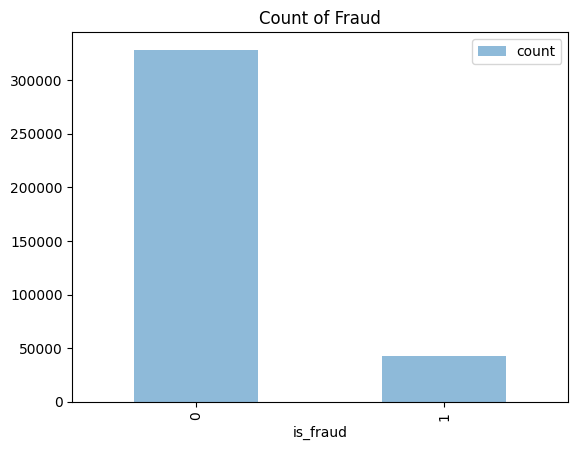

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

trainingSet = pd.read_csv("/content/drive/My Drive/train.csv")
testingSet = pd.read_csv("/content/drive/My Drive/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['is_fraud'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Fraud")
plt.show()

### Imports

In [50]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#from timezonefinder import TimezoneFinder
import pytz
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV, RFE
import shap

# Feature Engineering

In [51]:
# Timezone implementation attempt
def get_timezone(lat, lon):
    tf = TimezoneFinder()
    tz_str = tf.timezone_at(lng = lon, lat = lat)
    return pytz.timezone(tz_str) if tz_str else None

def get_timezone_diff(df):
    # Vectorize the timezone retrieval
    loc_tuples = list(zip(df['lat'], df['long']))
    merch_loc_tuples = list(zip(df['merch_lat'], df['merch_long']))

    # Get timezones in a vectorized manner
    tz_finder = TimezoneFinder()
    df['timezone'] = [tz_finder.timezone_at(lat=lat, lng=lon) for lat, lon in loc_tuples]
    df['merchant_timezone'] = [tz_finder.timezone_at(lat=lat, lng=lon) for lat, lon in merch_loc_tuples]

    # Convert to appropriate pytz timezones
    df['timezone'] = df['timezone'].apply(lambda x: pytz.timezone(x) if x else None)
    df['merchant_timezone'] = df['merchant_timezone'].apply(lambda x: pytz.timezone(x) if x else None)

    # Calculate timezone differences
    # This still uses apply but only on non-null entries and on much simpler lambda functions
    df['timezone_difference'] = df.apply(
        lambda x: (x['timezone'].utcoffset(x['trans_date_trans_time']) - x['merchant_timezone'].utcoffset(x['trans_date_trans_time'])).total_seconds() / 3600.0
        if x['timezone'] is not None and x['merchant_timezone'] is not None and x['trans_date_trans_time'] is not pd.NaT
        else None, axis=1)

    df.drop(['timezone', 'merchant_timezone'], axis=1, inplace=True)

    return df

In [52]:
def process_dates(df):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M').dt.tz_localize('UTC')
    df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')

    # extract the date and time into separate columns
    df['trans_date'] = df['trans_date_trans_time'].dt.date
    df['trans_time'] = df['trans_date_trans_time'].dt.time
    df['month'] = df['trans_date_trans_time'].dt.month
    df['day_of_month'] = df['trans_date_trans_time'].dt.day
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek

    return df

def encode_categorical_columns(df, categorical_columns):
    encoder = OrdinalEncoder()
    df[categorical_columns] = df[categorical_columns].apply(LabelEncoder().fit_transform)
    return df

def apply_target_encoding(df, column, target):

    means = df.groupby(column)[target].mean()
    df[f'{column}_target_enc'] = df[column].map(means)
    return df

def apply_one_hot_encoding(df, columns):
    for column in columns:
        one_hot_encoder = OneHotEncoder()
        one_hot_encoded = one_hot_encoder.fit_transform(df[[column]])
        df = df.join(pd.DataFrame(one_hot_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out([column])))
    return df

def encode(df):
    df = apply_target_encoding(df, 'merchant', 'is_fraud')  # High cardinality
    df = apply_target_encoding(df, 'street', 'is_fraud')  # High cardinality
    df = apply_target_encoding(df, 'job', 'is_fraud')  # High cardinality
    df = apply_one_hot_encoding(df, ['category', 'city', 'state'])  # Batch process low cardinality columns
    return df

def get_distance(row):
    cardholder_loc = (row['lat'], row['long'])
    merchant_loc = (row['merch_lat'], row['merch_long'])
    return geodesic(cardholder_loc, merchant_loc).kilometers

def get_unusual_trans(df, threshold=2):
    # unusual transaction amt: compare each trans amt to the usr historical avg. Flag if significantly higher/lower
    grouped = df.groupby('cc_num')['amt']
    df['avg_amt'] = grouped.transform('mean')
    df['std_amt'] = grouped.transform('std')
    df['unusual_trans'] = ((df['amt'] - df['avg_amt']).abs() > threshold * df['std_amt']).astype(int)
    return df

def process_dist_trans(df):
    df['distance'] = df.apply(get_distance, axis=1)

    df['daily_trans'] = df.groupby(['cc_num', df['trans_date']]).transform('count')['amt']

    df = get_unusual_trans(df, threshold=2)
    df.drop(columns=['avg_amt','std_amt', 'first', 'last', 'gender', 'trans_num'], inplace=True)

    return df

def process_city_jobs(df):
    job_counts = df['job'].value_counts().to_dict()
    df['job_freq'] = df['job'].map(job_counts)
    mean_fraud_by_job = df.groupby('job')['is_fraud'].mean()
    df['job_fraud_rate'] = df['job'].map(mean_fraud_by_job)

    df['city_pop_bin'] = pd.qcut(df['city_pop'], q=4, labels=False)  # Quartile-based binning
    df['city_pop_log'] = np.log1p(df['city_pop'])  # log1p so that log(0) does not occur
    df['amt_city_pop_interaction'] = df['amt'] * df['city_pop_log']
    return df

def process_region_data(df):
    # Group by region and calculate transaction frequency
    for region in ['city', 'state', 'zip']:
        df[f'{region}_trans_freq'] = df.groupby(region)['amt'].transform('count')

    # regional statistics for transaction amounts
    for region in ['city', 'state', 'zip']:
        df[f'{region}_avg_amt'] = df.groupby(region)['amt'].transform('mean')
        df[f'{region}_std_amt'] = df.groupby(region)['amt'].transform('std')

    # fraud rate by region
    for region in ['city', 'state', 'zip']:
        df[f'{region}_fraud_rate'] = df.groupby(region)['is_fraud'].transform('mean')

    return df

def interactions(df):
    # Multiplicative interactions
    df['street_amt_interaction'] = df['street_mean_encoded'] * df['amt']
    df['city_amt_interaction'] = df['city_mean_encoded'] * df['amt']
    df['trans_night_amt'] = df['trans_night'] * df['amt']
    df['cat_freq__amt_interaction'] = df['category_freq'] * df['amt']
    df['cat_freq_street_interaction'] = df['category_freq'] * df['street_amt_interaction']
    df['trans_night_amt_cat_freq_interaction']=df['category_freq'] * df['trans_night_amt']
    df['city_pop_amt_interaction'] = df['city_pop'] * df['amt']
    df['age_daily_trans_interaction'] = df['age'] * df['daily_trans']
    df['dist_amt_interaction'] = df['distance'] * df['amt']
    df['avg_amt_trans_interaction'] = df['daily_trans'] * df['mean']
    df['interaction_job_freq_amt'] = df['job_freq'] * df['amt']
    df['interaction_job_fraud_rate_amt'] = df['job_fraud_rate'] * df['amt']
    df['trans_night_street_interaction']=df['street_amt_interaction'] * df['trans_night_amt']

    std_dev_amount_per_category = df.groupby('category_encoded')['amt'].std().reset_index(name='std_dev_amt_per_category')
    df = df.merge(std_dev_amount_per_category, on='category_encoded', how='left')

    return df

def process_stats(df):
    """
    computes merchant risk scores, category risk factors, and RFM features
    for different time windows
    """

    time_windows = [1, 7, 30]
    delay_days = 7
    now = df['trans_date_trans_time'].max()

    for window_days in time_windows:
        window_end = now - pd.Timedelta(days=delay_days)
        window_start = window_end - pd.Timedelta(days=window_days)
        window_transactions = df[(df['trans_date_trans_time'] >= window_start) & (df['trans_date_trans_time'] < window_end)]

        # merchant risk scores
        merchant_risk = window_transactions.groupby('merchant')['is_fraud'].mean().reset_index(name=f'risk_score_{window_days}days')
        df = df.merge(merchant_risk, on='merchant', how='left', suffixes=('', f'_{window_days}days'))

        # category risk factors
        category_risk = window_transactions.groupby('category')['is_fraud'].mean().reset_index(name=f'category_risk_{window_days}days')
        df = df.merge(category_risk, on='category', how='left', suffixes=('', f'_{window_days}days'))

        # RFM features for each cardholder
        rfm = window_transactions.groupby('cc_num')['amt'].agg(['count', 'mean']).reset_index().rename(columns={'count': f'freq_{window_days}days', 'mean': f'avg_amt_{window_days}days'})
        df = df.merge(rfm, on='cc_num', how='left')

    if 'mean' not in df.columns:
        df['mean'] = df.groupby('cc_num')['amt'].transform('mean')

    df = df.loc[:,~df.columns.duplicated()]

    return df


def night_day(df):
    df['trans_weekend'] = df['trans_date_trans_time'].dt.weekday >= 5
    df['trans_night'] = df['trans_date_trans_time'].dt.hour.apply(lambda x: 1 if 0 <= x < 6 or 20 <= x < 24 else 0)
    return df

def cat(df):
    categorical_columns = ['street', 'city', 'state']
    df = encode_categorical_columns(df, categorical_columns)
    for col in categorical_columns:
        mean_encoding = df.groupby(col)['is_fraud'].mean()
        df[f"{col}_mean_encoded"] = df[col].map(mean_encoding)

    categorical_features = ['merchant', 'city', 'state', 'job', 'street']
    df[categorical_features] = df[categorical_features].apply(LabelEncoder().fit_transform)
    df['category_encoded'] = LabelEncoder().fit_transform(df['category'])
    category_freq = df['category_encoded'].value_counts().reset_index()
    category_freq.columns = ['category_encoded', 'category_freq']
    df = pd.merge(df, category_freq, on='category_encoded', how='left')
    return df

def add_polynomial_features(df, feature_cols, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[feature_cols])
    feature_names = [f"poly_{i}" for i in range(poly_features.shape[1])]
    df_poly = pd.DataFrame(poly_features, columns=feature_names, index=df.index)
    return pd.concat([df, df_poly], axis=1)

def polynomial(df):
    df = add_polynomial_features(df, ['amt', 'city_pop_log'], degree=2)

    df['amt_binned'] = pd.cut(df['amt'], bins=[0, 100, 500, 1000, np.inf], labels=['low', 'medium', 'high', 'very_high'])

    # rolling aggregates
    df.sort_values(by=['cc_num', 'trans_date_trans_time'], inplace=True)  # Make sure the data is sorted
    df['rolling_avg_amt'] = df.groupby('cc_num')['amt'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

    # time since last transaction
    df['time_since_last_trans'] = df.groupby('cc_num')['trans_date_trans_time'].diff().apply(lambda x: x.total_seconds())

    # frequency encoding
    category_counts = df['category'].value_counts(normalize=True)
    df['category_freq_encode'] = df['category'].map(category_counts)
    return df

def calculate_age(dob, trans_date):
    age = trans_date.year - dob.year - ((trans_date.month, trans_date.day) < (dob.month, dob.day))
    return age

def age(df):
    df['age'] = df.apply(lambda row: calculate_age(row['dob'], row['trans_date_trans_time']), axis=1)

    return df

In [53]:
print(trainingSet.columns)

Index(['id', 'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category',
       'amt', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'merchant', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')


In [54]:
trainingSet = pd.read_csv("/content/drive/My Drive/train.csv")
print("processing dates")
# Combine 'trans_date' and 'trans_time' into a single column
trainingSet['trans_date_trans_time'] = trainingSet['trans_date'] + " " + trainingSet['trans_time']

# Convert the new column to a datetime object
trainingSet['trans_date_trans_time'] = pd.to_datetime(trainingSet['trans_date_trans_time'])

def process_dates(df):
    # Ensure 'trans_date_trans_time' is parsed correctly
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Correct format for 'dob'
    df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d', errors='coerce')

    # Example: Extract year of birth if needed
    df['year_of_birth'] = df['dob'].dt.year

    return df


print(trainingSet['trans_date_trans_time'].head())

train_processed = process_dates(trainingSet)


print("processing distances, transactions")
train_processed = process_dist_trans(trainingSet)


print("processing city, jobs")
train_processed = process_city_jobs(train_processed)
train_processed_after_dist_trans_city_jobs = train_processed


print("processing categories")
train_processed = cat(train_processed)
train_processed_after_dist_trans_city_jobs_cats = train_processed

processing dates
0   2024-01-10 06:49:39
1   2024-01-06 02:37:50
2   2024-01-18 21:40:21
3   2024-01-21 16:20:15
4   2024-01-21 19:36:26
Name: trans_date_trans_time, dtype: datetime64[ns]
processing distances, transactions
processing city, jobs
processing categories


In [55]:
print("processing polynomials")
train_processed = polynomial(train_processed)


print("processing age")
train_processed = age(train_processed)

processing polynomials
processing age


In [56]:
def scale(df):
    features_to_scale = ['amt', 'city_pop', 'rolling_avg_amt', 'time_since_last_trans']
    scaler = StandardScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    return df
train_processed = scale(train_processed)

In [57]:
print("processing cardholder stats")
train_processed = process_stats(train_processed)

print("processing time transactions")
train_processed = night_day(train_processed)

print("processing interactions")
train_processed = interactions(train_processed)
#train_processed = cluster_locations(train_processed)

processing cardholder stats
processing time transactions
processing interactions


In [58]:
train_processed.head()

,id,trans_date,trans_time,unix_time,category,amt,cc_num,street,city,state,...,cat_freq_street_interaction,trans_night_amt_cat_freq_interaction,city_pop_amt_interaction,age_daily_trans_interaction,dist_amt_interaction,avg_amt_trans_interaction,interaction_job_freq_amt,interaction_job_fraud_rate_amt,trans_night_street_interaction,std_dev_amt_per_category
0,389329,2024-01-02,02:57:13,1704182233,gas_transport,-0.482284,60400268763,11472,225,20,...,-3670.733382,-12847.566836,-0.287415,54,-21.025801,0.533045,-303.356715,-0.065174,0.066457,0.551781
1,114880,2024-01-04,01:10:52,1704348652,gas_transport,-0.482039,60400268763,11472,225,20,...,-3668.868004,-12841.038013,-0.287269,54,-35.951669,0.533045,-303.202557,-0.065140,0.066389,0.551781
2,247180,2024-01-05,11:05:27,1704470727,grocery_pos,-0.171312,60400268763,11472,225,20,...,-1970.870037,-0.000000,-0.102093,54,-18.767108,0.533045,-107.755188,-0.023150,0.000000,0.794479
3,14783,2024-01-07,10:08:54,1704640134,gas_transport,0.804903,60400268763,11472,225,20,...,6126.232789,0.000000,0.479678,108,73.680060,1.066091,506.284075,0.108771,0.000000,0.551781
4,294522,2024-01-07,23:16:39,1704687399,shopping_net,4.266731,60400268763,11472,225,20,...,40689.985356,142414.948745,2.542739,108,470.945168,1.066091,2683.773826,0.576585,5.201427,1.560692


In [59]:
def drop_time_related_columns(df):
    columns_to_drop = ['poly_4', 'freq_1days', 'freq_7days', 'long', 'job_fraud_rate', 'trans_night', 'zip', 'state',
                       'unusual_trans', 'job', 'street', 'merch_lat', 'avg_amt_30days', 'location_cluster', 'avg_amt_1days',
                       'risk_score_1days', 'merchant', 'poly_0', 'category_risk_1days', 'city_pop_bin', 'trans_weekend',
                       'state_mean_encoded', 'cc_num', 'category_freq_encode', 'job_freq', 'dist_amt_interaction', 'month',
                       'lat', 'distance', 'freq_30days', 'merch_long', 'city', 'avg_amt_7days', 'city_pop_log', 'poly_2',
                       'poly_3', 'poly_1', 'location_cluster', 'max', 'interaction_job_freq_amt', 'interaction_job_fraud_rate_amt',
                       'day_of_month', 'std', 'city_pop', 'city_amt_interaction']
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

train_processed = drop_time_related_columns(train_processed)

In [60]:
numeric_df = train_processed.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Get the correlation with the target variable
target_corr = corr_matrix['is_fraud'].drop('is_fraud')  # Drop self-correlation

# Sort the values to see the most correlated features at the top
sorted_corr = target_corr.abs().sort_values(ascending=False)

print(sorted_corr)


trans_night_amt                         0.572545
trans_night_amt_cat_freq_interaction    0.565335
amt                                     0.563626
cat_freq__amt_interaction               0.560224
amt_city_pop_interaction                0.550974
street_amt_interaction                  0.483675
rolling_avg_amt                         0.482423
cat_freq_street_interaction             0.476994
street_mean_encoded                     0.436056
avg_amt_trans_interaction               0.383962
mean                                    0.343559
trans_night_street_interaction          0.221044
city_mean_encoded                       0.214618
std_dev_amt_per_category                0.168619
category_risk_7days                     0.122909
risk_score_7days                        0.117961
unix_time                               0.106750
age_daily_trans_interaction             0.102777
year_of_birth                           0.100323
age                                     0.100139
category_freq       

In [61]:
from google.colab import drive
drive.mount('/content/drive')

submissionSet = pd.read_csv("/content/drive/MyDrive/test.csv")

testX= pd.merge(train_processed, submissionSet, left_on='id', right_on='id')


trainX =  train_processed[train_processed['is_fraud'].notnull()]

testX.to_csv("/content/drive/MyDrive/X_test.csv", index=False)
trainX.to_csv("/content/drive/MyDrive/X_train.csv", index=False)


X_train = pd.read_csv("/content/drive/MyDrive/X_train.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['is_fraud'], axis=1),
        X_train['is_fraud'],
        test_size=1/10.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed = X_train._get_numeric_data()
print(X_train_processed.columns)
X_test_processed = X_test._get_numeric_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['id', 'unix_time', 'amt', 'year_of_birth', 'daily_trans',
       'amt_city_pop_interaction', 'street_mean_encoded', 'city_mean_encoded',
       'category_encoded', 'category_freq', 'rolling_avg_amt',
       'time_since_last_trans', 'age', 'risk_score_7days',
       'category_risk_7days', 'risk_score_30days', 'category_risk_30days',
       'mean', 'street_amt_interaction', 'trans_night_amt',
       'cat_freq__amt_interaction', 'cat_freq_street_interaction',
       'trans_night_amt_cat_freq_interaction', 'city_pop_amt_interaction',
       'age_daily_trans_interaction', 'avg_amt_trans_interaction',
       'trans_night_street_interaction', 'std_dev_amt_per_category'],
      dtype='object')


In [62]:
from xgboost import XGBClassifier
import pickle

# Train the model (example)
model = XGBClassifier()
model.fit(X_train_processed, Y_train)

# Save the model
with open('xgboost_model.obj', 'wb') as f:
    pickle.dump(model, f)

# Load the model
with open('xgboost_model.obj', 'rb') as f:
    xgb_model = pickle.load(f)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:16:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on testing set =  0.9942003183081115
F1 score on testing set =  0.9743467366662689


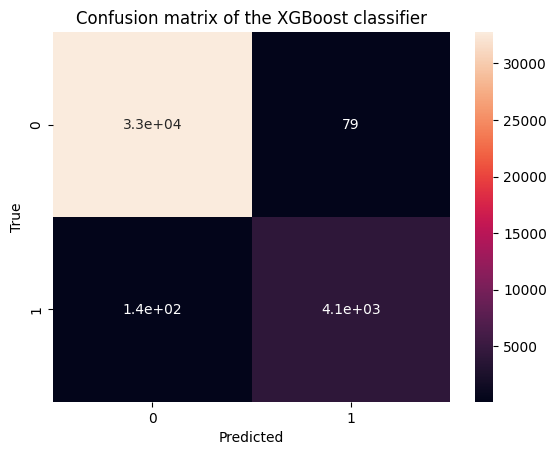

In [68]:
# Learn the model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss').fit(X_train_processed, Y_train)

# pickle model - saves it so you can load it later
with open('xgb_model.obj', 'wb') as f:
    pickle.dump(model, f)
# to load pickled model:
# with open('xgb_model.obj', 'rb') as f:
#    model = pickle.load(f)

# Evaluate your model on the testing set
Y_test_predictions = model.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("F1 score on testing set = ", f1_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the XGBoost classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [69]:
import pandas as pd

# Load sample submission file
sample_submission_path = '/content/drive/My Drive/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# Check structure
print(sample_submission.head())


       id  is_fraud
0   52329         0
1   92215         0
2  107070         0
3  117508         0
4  525132         0


In [75]:
print(f"Original test dataset shape: {pd.read_csv('/content/drive/My Drive/test.csv').shape}")
print(f"Processed testX shape: {testX.shape}")


Original test dataset shape: (92676, 23)
Processed testX shape: (0, 28)


In [76]:
# Truncate test_ids or extend Y_test_predictions to match lengths (temporary fix)
min_length = min(len(test_ids), len(Y_test_predictions))
test_ids = test_ids[:min_length]
Y_test_predictions = Y_test_predictions[:min_length]

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'is_fraud': Y_test_predictions
})

# Save and download the submission file
submission.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
original_test = pd.read_csv('/content/drive/My Drive/test.csv')
print(original_test.columns)
print(f"Original test shape: {original_test.shape}")

Index(['id', 'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category',
       'amt', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'merchant', 'merch_lat',
       'merch_long'],
      dtype='object')
Original test shape: (92676, 23)


In [82]:
if 'trans_date_trans_time' in original_test.columns:
    original_test['trans_date_trans_time'] = pd.to_datetime(original_test['trans_date_trans_time'], errors='coerce')
    # Check for NaN values introduced during conversion
    print(original_test['trans_date_trans_time'].isnull().sum())

    # Fill missing datetime values
    original_test['trans_date_trans_time'] = original_test['trans_date_trans_time'].fillna(method='bfill')
    original_test['year'] = original_test['trans_date_trans_time'].dt.year
    original_test['month'] = original_test['trans_date_trans_time'].dt.month
    original_test['day'] = original_test['trans_date_trans_time'].dt.day
    original_test['hour'] = original_test['trans_date_trans_time'].dt.hour
else:
    print("Column 'trans_date_trans_time' not found.")

Column 'trans_date_trans_time' not found.


In [83]:
from sklearn.preprocessing import LabelEncoder

for col in original_test.select_dtypes(include=['object', 'category']).columns:
    print(f"Encoding column: {col}")
    original_test[col] = LabelEncoder().fit_transform(original_test[col].astype(str))

Encoding column: trans_num
Encoding column: trans_date
Encoding column: trans_time
Encoding column: category
Encoding column: first
Encoding column: last
Encoding column: gender
Encoding column: street
Encoding column: city
Encoding column: state
Encoding column: job
Encoding column: dob
Encoding column: merchant


In [84]:
# Align features with the training set
for col in model.feature_names_in_:
    if col not in original_test.columns:
        original_test[col] = 0  # Add missing columns with default values

testX = original_test[model.feature_names_in_]
print(f"Processed testX shape: {testX.shape}")

Processed testX shape: (92676, 28)


In [85]:
Y_test_predictions = model.predict(testX)
print(f"Number of predictions: {len(Y_test_predictions)}")

Number of predictions: 92676


In [86]:
# Load test IDs from the sample submission file
test_ids = pd.read_csv('/content/drive/My Drive/sample_submission.csv')['id']

# Ensure alignment of IDs and predictions
submission = pd.DataFrame({
    'id': test_ids,
    'is_fraud': Y_test_predictions
})

# Save and download the submission file
submission.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
print(f"Submission shape: {submission.shape}")

Submission shape: (92676, 2)


In [88]:
importances = model.feature_importances_

# Map feature importances to the corresponding feature names
feature_names = X_train_processed.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature importances:", sorted_features)

Feature importances: [('cat_freq_street_interaction', 0.41702333), ('trans_night_amt', 0.12966229), ('amt', 0.10657682), ('trans_night_street_interaction', 0.064656496), ('category_risk_30days', 0.058896735), ('category_risk_7days', 0.028302997), ('daily_trans', 0.024563259), ('unix_time', 0.024558576), ('std_dev_amt_per_category', 0.018531874), ('category_freq', 0.018304935), ('rolling_avg_amt', 0.015459382), ('street_mean_encoded', 0.015240084), ('category_encoded', 0.0112633575), ('risk_score_7days', 0.007677696), ('mean', 0.0071030776), ('time_since_last_trans', 0.0066599306), ('year_of_birth', 0.006133585), ('street_amt_interaction', 0.0058932975), ('age_daily_trans_interaction', 0.005301324), ('cat_freq__amt_interaction', 0.00509577), ('avg_amt_trans_interaction', 0.004419865), ('age', 0.0041368525), ('risk_score_30days', 0.004086784), ('amt_city_pop_interaction', 0.0038927), ('trans_night_amt_cat_freq_interaction', 0.0029280046), ('city_pop_amt_interaction', 0.0015541567), ('id'

In [89]:
# Combine features and target variable into one DataFrame
df_analysis = pd.concat([X_train_processed, Y_train], axis=1)

correlations = df_analysis.corr()['is_fraud'].sort_values(ascending=False)
print(correlations)

is_fraud                                1.000000
trans_night_amt                         0.572133
trans_night_amt_cat_freq_interaction    0.564484
amt                                     0.560571
cat_freq__amt_interaction               0.557104
amt_city_pop_interaction                0.547962
street_amt_interaction                  0.483453
rolling_avg_amt                         0.481557
cat_freq_street_interaction             0.476655
street_mean_encoded                     0.434590
avg_amt_trans_interaction               0.382517
mean                                    0.341662
city_mean_encoded                       0.213665
trans_night_street_interaction          0.212154
std_dev_amt_per_category                0.168811
category_risk_7days                     0.122248
risk_score_7days                        0.117419
age_daily_trans_interaction             0.102563
age                                     0.099454
category_freq                           0.097044
category_encoded    

In [90]:
# RFE selector with an XGBoost model and number of features
selector = RFE(model, n_features_to_select=37, step=1)
selector = selector.fit(X_train_processed, Y_train)

# Get the mask of selected features
selected_features = X_train_processed.columns[selector.support_]
print("Selected features:", selected_features)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=37 > n_features=28. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:27:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected features: Index(['id', 'unix_time', 'amt', 'year_of_birth', 'daily_trans',
       'amt_city_pop_interaction', 'street_mean_encoded', 'city_mean_encoded',
       'category_encoded', 'category_freq', 'rolling_avg_amt',
       'time_since_last_trans', 'age', 'risk_score_7days',
       'category_risk_7days', 'risk_score_30days', 'category_risk_30days',
       'mean', 'street_amt_interaction', 'trans_night_amt',
       'cat_freq__amt_interaction', 'cat_freq_street_interaction',
       'trans_night_amt_cat_freq_interaction', 'city_pop_amt_interaction',
       'age_daily_trans_interaction', 'avg_amt_trans_interaction',
       'trans_night_street_interaction', 'std_dev_amt_per_category'],
      dtype='object')


In [91]:
columns_difference = set(X_train_processed.columns) - set(selected_features)

print(columns_difference)

set()


cat_freq_street_interaction
trans_night_amt
amt
trans_night_street_interaction
category_risk_30days
category_risk_7days
daily_trans
unix_time
std_dev_amt_per_category
category_freq
rolling_avg_amt
street_mean_encoded
category_encoded
risk_score_7days
mean
time_since_last_trans
year_of_birth
street_amt_interaction
age_daily_trans_interaction
cat_freq__amt_interaction
avg_amt_trans_interaction
age
risk_score_30days
amt_city_pop_interaction
trans_night_amt_cat_freq_interaction
city_pop_amt_interaction
id
city_mean_encoded


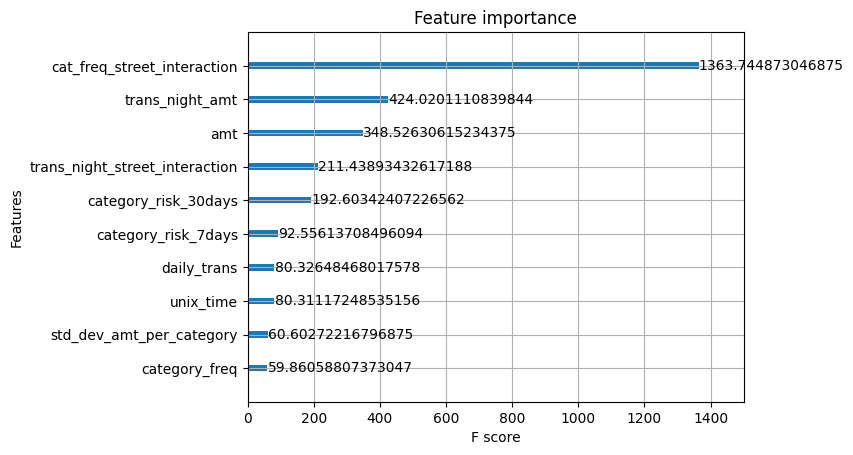

In [92]:
sorted_features = [feature for _, feature in sorted(zip(importances, feature_names), reverse=True)]
for i in sorted_features:
    print(i)

xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.show()

In [ ]:
X_train_numeric = X_train.select_dtypes(include=['number'])

explainer = shap.TreeExplainer(model)

# SHAP values
shap_values = explainer.shap_values(X_train_numeric)

# summary plot for the SHAP values of the numerical features
shap.summary_plot(shap_values, X_train_numeric, feature_names=X_train_numeric.columns)

In [94]:
# Load test IDs from the sample submission file
test_ids = pd.read_csv('/content/drive/My Drive/sample_submission.csv')['id']

# Ensure alignment of IDs and predictions
submission = pd.DataFrame({
    'id': test_ids,
    'is_fraud': Y_test_predictions
})

# Save and download the submission file
submission.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>